Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.008524864912033
Epoch 2, Loss: 0.9630035609006882
Epoch 3, Loss: 0.9730495437979698


C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarnin

              precision    recall  f1-score   support

    Dementia       0.00      0.00      0.00         2
          HC       0.64      0.70      0.67        20
         MCI       0.30      0.30      0.30        10

    accuracy                           0.53        32
   macro avg       0.31      0.33      0.32        32
weighted avg       0.49      0.53      0.51        32



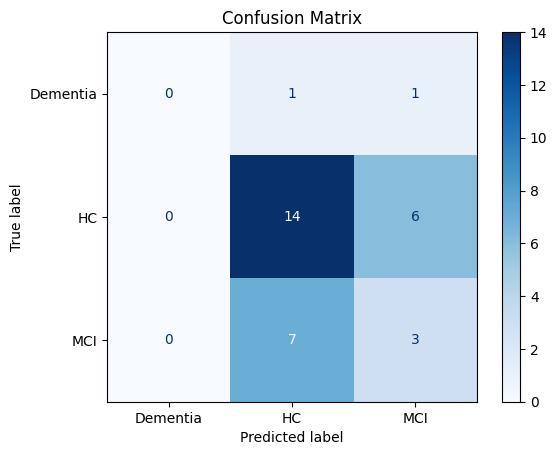

In [3]:
import os
import re
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load Helper Function
def load_data(file_pattern):
    data = []
    record_ids = []
    for root, _, files in os.walk("../process/PROCESS-V1/"):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

def load_labels(label_file):
    df = pd.read_csv(label_file)
    df['label'] = df['Class'].astype('category').cat.codes  # Konvertiere Klassen zu numerischen Werten
    label_map = df.set_index('Record-ID')['label'].to_dict()
    return label_map, dict(enumerate(df['Class'].astype('category').cat.categories))

# Custom Dataset class for PyTorch
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load Data
label_file = "../process/PROCESS-V1/dem-info.csv"
labels, class_mapping = load_labels(label_file)
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern)

# Map Labels
y = [labels.get(record_id, 0) for record_id in record_ids]

if not data or not y:
    raise ValueError("No matching data or labels found. Check your file paths or label mapping.")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Load Pretrained Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(class_mapping))

# Prepare DataLoader
max_len = 512
train_dataset = CustomTextDataset(X_train, y_train, tokenizer, max_len)
test_dataset = CustomTextDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training Loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):  # num_train_epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluate Model
y_pred = []
true_labels = []
model.eval()

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        y_pred.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(true_labels, y_pred, target_names=[class_mapping[i] for i in range(len(class_mapping))]))

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_mapping[i] for i in range(len(class_mapping))])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
